In [1]:
# '''import all necessary packages'''

import numpy as np
import pandas as pd
import re

# for regression
from statsmodels.formula.api import ols

# for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk
nltk.download('vader_lexicon')

from transformers import pipeline

from stargazer.stargazer import Stargazer

from afinn import Afinn
from tqdm.auto import tqdm
tqdm.pandas()

# for visulization
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
# pip install SciencePlots
# pip install git+https://github.com/garrettj403/SciencePlots
# pip install --upgrade pip
import scienceplots
plt.style.use('science')

# for supervised machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from nltk.tokenize import TweetTokenizer
from collections import Counter

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/buluo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
new_df = pd.read_csv('new_df.csv')

In [4]:
new_df[['name','Date','Close']].head()

,name,Date,Close
0,0xPolygon,2022-11-02,0.871718
1,0xPolygon,2022-11-03,0.952122
2,0xPolygon,2022-11-04,1.169746
3,0xPolygon,2022-11-05,1.183722
4,0xPolygon,2022-11-06,1.137968


In [6]:
print(new_df.columns)
df=new_df[['name', 'Date', 'text', 'sum','Close']]
df.head(2)

Index(['subreddit', 'Date', 'text', 'sum', 'Open', 'High', 'Low', 'Close',
       'Adj Close', 'Volume', 'name', 'returns', 'Yesterday_returns', 'gain',
       'Yesterday_gain', 'three_day_returns', 'seven_day_returns',
       'three_day_volatility', 'seven_day_volatility', 'frequency_log'],
      dtype='object')


,name,Date,text,sum,Close
0,0xPolygon,2022-11-02,NaN,NaN,0.871718
1,0xPolygon,2022-11-03,Unique Chance to Own a Top Web3 Domain! nan In...,2.0,0.952122


In [23]:
def genefina(test):
    test['Return'] = test['Close'].pct_change()
    test['Two_Day_Return'] = (test['Close'] / test['Close'].shift(2)) - 1
    test['Three_Day_Return'] = (test['Close'] / test['Close'].shift(3)) - 1
    test['Four_Day_Return'] = (test['Close'] / test['Close'].shift(4)) - 1
    test['Five_Day_Return'] = (test['Close'] / test['Close'].shift(5)) - 1
    test['Six_Day_Return'] = (test['Close'] / test['Close'].shift(6)) - 1
    test['Seven_Day_Return'] = (test['Close'] / test['Close'].shift(7)) - 1
    
    Volatility = test['Return'].std()

    test['Gain'] = ['Yes' if x > 2 * Volatility else 'No' for x in test['Return']]
    test['Loss'] = ['Yes' if x < -2 * Volatility else 'No' for x in test['Return']]
    Three_Day_Gain = []
    Three_Day_Loss = []
    for x in test['Three_Day_Return']:
        if np.isnan(x):
            Three_Day_Gain.append(x)
            Three_Day_Loss.append(x)
        elif x > 2 * Volatility:
            Three_Day_Gain.append('Yes')
            Three_Day_Loss.append('No')
        elif x < -2 * Volatility:
            Three_Day_Gain.append('No')
            Three_Day_Loss.append('Yes')
        else:
            Three_Day_Gain.append('No')
            Three_Day_Loss.append('No')

    test['Three_Day_Gain'] = Three_Day_Gain
    test['Three_Day_Loss'] = Three_Day_Loss
   
    test['Three_Day_Volatility'] = test['Return'].rolling(window=3).std()
    test['Four_Day_Volatility'] = test['Return'].rolling(window=4).std()
    test['Five_Day_Volatility'] = test['Return'].rolling(window=5).std()
    test['Six_Day_Volatility'] = test['Return'].rolling(window=6).std()
    test['Seven_Day_Volatility'] = test['Return'].rolling(window=7).std()

In [24]:
new_df = pd.DataFrame()

for i in df.name.unique():
    test = df[df['name'] == i]
    genefina(test)
    new_df = pd.concat([new_df, test])

/Users/buluo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/buluo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/buluo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [29]:
new_text = []
count=0
for x in new_df.text:
    if type(x) == str:
        x = x.lower()
        x = re.sub('@[^\s]+','',x)
        x = re.sub(r"http\S+", "", x)
        x = ' '.join(re.findall(r'\w+', x))
        x = re.sub(r'\s+[a-zA-Z]\s+', '', x)
        x = re.sub(r'\s+', ' ', x, flags=re.I)
        new_text.append(x)
    else:
        new_text.append(x)
        count += 1

In [30]:
sid = SIA()

compound = []

for x in new_text:
    if type(x) == str:
        x = sid.polarity_scores(x)
        compound.append(x['compound'])
    else:
        compound.append(np.nan)

new_df['sentiment'] = compound

In [31]:
# new_df[new_df['frequency'] == 0]
new_df['sentiment'] = [0 if np.isnan(i) else i for i in new_df['sentiment']]

In [32]:
new_df['frequency'] = [0 if np.isnan(i) else i for i in new_df['sum']]

In [33]:
# calculate the natural logarithm (base e) of sum
new_df['frequency_log'] = np.log(new_df['frequency']+1)

In [34]:
new_df = new_df[new_df.Date>'2022-11-02']
new_df = new_df[new_df.Date<'2023-03-23']
# new_df

In [35]:
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df['Weekday'] = new_df['Date'].dt.weekday
new_df['Month'] = new_df['Date'].dt.month
# new_df

In [36]:
new_df[['Gain','Loss']].describe()

,Gain,Loss
count,1400,1400
unique,2,2
top,No,No
freq,1364,1372


In [37]:
new_df['Three_Day_Loss'].value_counts()

No     1314
Yes      66
Name: Three_Day_Loss, dtype: int64

In [235]:
new_df.columns[12:16].tolist()

['Gain', 'Loss', 'Three_Day_Gain', 'Three_Day_Loss']

In [237]:
IV = new_df.columns[12:16].tolist()
IV
dep_var = 'frequency_log'
sen_var = 'sentiment'

In [42]:
# mod1 = ols(formula='sentiment ~ C(Gain)+C(Loss)', data = new_df).fit(cov_type='HC0') 
# mod2 = ols(formula='sentiment ~ C(Gain)+C(Loss)+C(name)+C(Month)+C(Weekday)', data = new_df).fit(cov_type='HC0') 
mod3 = ols(formula='sentiment ~ C(Three_Day_Gain)+C(Three_Day_Loss)', data = new_df).fit(cov_type='HC0') 
mod4 = ols(formula='sentiment ~ C(Three_Day_Gain)+C(Three_Day_Loss)+C(name)+C(Month)+C(Weekday)', data = new_df).fit(cov_type='HC0') 

In [43]:
table_result = Stargazer([mod3, mod4])
table_result

In [123]:
new_df.columns[5:12].tolist()[::-1]

['Seven_Day_Return',
 'Six_Day_Return',
 'Five_Day_Return',
 'Four_Day_Return',
 'Three_Day_Return',
 'Two_Day_Return',
 'Return']

In [238]:
models = []
for var in IV:
    
    mod = ols(formula=f'{dep_var} ~ {var}+name+C(Month)+C(Weekday)', data = new_df).fit(cov_type='HC0') 

    models.append(mod)
    
#Looking at the results
table_result = Stargazer(models)

#Adding the variable names to each model
# table_result.custom_columns(DV_1w, [1 for i in range(len(DV_1w))])
table_result
# print(table_result.render_latex())

In [146]:
models_c = []
for var in IV:
    
    mod = ols(formula=f'{dep_var} ~ {var}+name+C(Weekday)+C(Month)', data = new_df[new_df.name != 'USDC']).fit(cov_type='HC0') 

    models_c.append(mod)
    
#Looking at the results
table_result = Stargazer(models_c)
table_result
#Adding the variable names to each model
# table_result.custom_columns(DV_1w, [1 for i in range(len(DV_1w))])
# table_result
# print(table_result.render_latex())

In [56]:
new_df.columns[16:21].tolist()

['Three_Day_Volatility',
 'Four_Day_Volatility',
 'Five_Day_Volatility',
 'Six_Day_Volatility',
 'Seven_Day_Volatility']

In [99]:
IV = new_df.columns[16:21].tolist()
IV
dep_var = 'frequency_log'
sen_var = 'sentiment'

In [126]:
IV = new_df.columns[5:12].tolist()
IV
dep_var = 'frequency_log'
sen_var = 'sentiment'

In [127]:
models_dep = []
for var in IV:
    
    mod = ols(formula=f'{dep_var} ~ {var}+name+C(Month)+C(Weekday)', data = new_df).fit(cov_type='HC0') 

    models_dep.append(mod)
    
#Looking at the results
table_result = Stargazer(models_dep)

#Adding the variable names to each model
# table_result.custom_columns(DV_1w, [1 for i in range(len(DV_1w))])
# table_result
# print(table_result.render_latex())

In [97]:
for mod in models_sen:
#     coefs_sen.append(mod.params[1])
#     std_errors_sen.append(mod.bse[1])
    p_values_sen.append(mod.pvalues[1])

In [111]:
models_dep[0].params[-1]

2.119045714352879

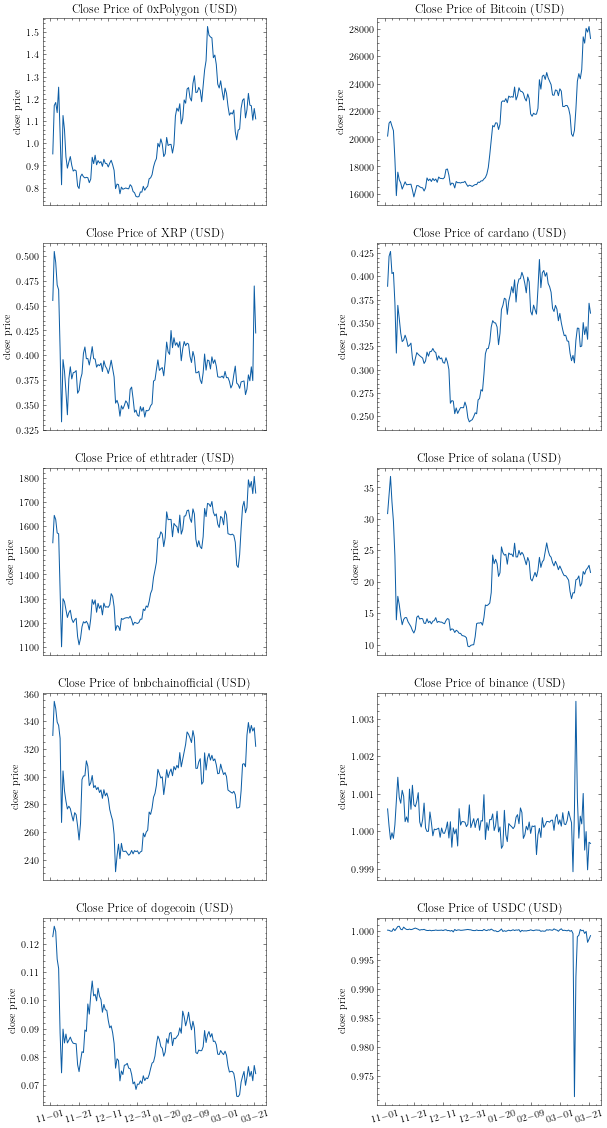

In [138]:
with plt.style.context(['science']):
    fig, axs = plt.subplots(5, 2, figsize=(10,20),sharex=True, gridspec_kw={'wspace': 0.5})
    for ax, pic in zip(axs.flat, new_df['name'].unique()):
        ax.set_title(f'Close Price of {pic} (USD)')
        ax.plot(new_df[new_df.name == pic]['Date'], new_df[new_df.name == pic]['Close'])
        ax.set_ylabel('close price')
#         ax2 = ax.twinx()
#         ax.bar(new_df[new_df.name == pic]['Date'], new_df[new_df.name == pic]['sum'], alpha=0.2)
#         ax2.set_ylabel('Frequency')
#         # Set the x-axis to show 10 days per point   
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=20))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=15)
#         fig.savefig('graph/Close.png', dpi=300)

In [129]:
models_sen = []
for var in IV:
    
    mod = ols(formula=f'{sen_var} ~ {var}+name+C(Month)+C(Weekday)', data = new_df).fit(cov_type='HC0') 

    models_sen.append(mod)
    
#Looking at the results
table_result = Stargazer(models_sen)

#Adding the variable names to each model
# table_result.custom_columns(DV_1w, [1 for i in range(len(DV_1w))])
# table_result
# print(table_result.render_latex())

/Users/buluo/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2788: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/Users/buluo/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2788: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


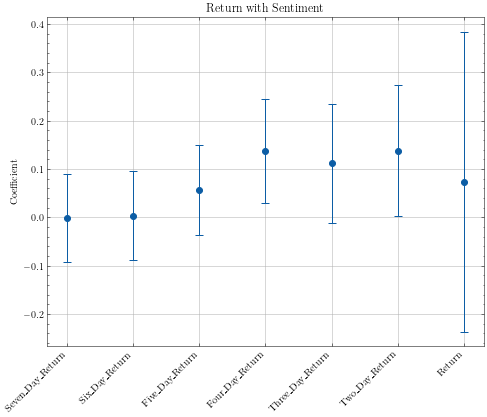

In [130]:
with plt.style.context(['science']):
    fig, axs = plt.subplots(1, 1, figsize=(7, 6))

    # Initialize the x-axis values
    x_values = np.arange(len(IV))[::-1]
    
    # Define the desired order of variables
    desired_order = IV[::-1]
    
    # Initialize lists to store coefficient values and their standard errors
    coefs = []
    std_errors = []
    p_values = []
    
    for mod in models_sen:
        for var_name in desired_order:
            if var_name in mod.params.index.to_list():
                var_index = mod.params.index.get_loc(var_name)
                coefs.append(mod.params[var_index])
                std_errors.append(mod.bse[var_index])
                p_values.append(mod.pvalues[var_index])

    # Plot the coefficients with error bars
    axs.errorbar(x_values, coefs, yerr=std_errors, fmt='o', capsize=4)
    
        # Add asterisks to indicate significance level
    for i, p_val in enumerate(p_values):
        if p_val < 0.001:
            axs.text(x_values[i]+0.08, coefs[i], '***', ha='left')
        elif p_val < 0.01:
            axs.text(x_values[i]+0.08, coefs[i], '**', ha='left')
        elif p_val < 0.05:
            axs.text(x_values[i]+0.08, coefs[i], '*', ha='left')

    # Customize the plot
    axs.set_xticks(x_values)
#     axs.set_xticklabels(IV)
    axs.set_xticklabels(IV, rotation=45, ha='right')  # Rotate the x-axis labels for better readability
#     axs[0].set_xlabel('Independent Variable')
    axs.set_ylabel('Coefficient')
    axs.set_title('Return with Sentiment')
    axs.grid(True)
    
#     # Iterate over the regression models for the second graph
#     coefs_sen = []
#     std_errors_sen = []
#     p_values_sen = []
#     for mod in models_sen:
#         coefs_sen.append(mod.params[1])
#         std_errors_sen.append(mod.bse[1])
#         p_values_sen.append(mod.pvalues[1])

#     # Plot the coefficients with error bars for the second graph
#     axs.errorbar(x_values, coefs_sen, yerr=std_errors_sen, fmt='o', capsize=4)
    
#         # Add asterisks to indicate significance level for the second graph
#     for i, p_val_sen in enumerate(p_values_sen):
#         if p_val_sen < 0.001:
#             axs.text(x_values[i], coefs_sen[i], '***')
#         elif p_val_sen < 0.01:
#             axs.text(x_values[i], coefs_sen[i], '**')
#         elif p_val_sen < 0.05:
#             axs.text(x_values[i], coefs_sen[i], '*')

#     # Customize the plot for the second graph
#     axs.set_xticks(x_values)
#     axs.set_xticklabels(IV, rotation=45, ha='right')  # Rotate the x-axis labels for better readability
# #     axs[1].set_xlabel('Independent Variable')
#     axs.set_ylabel('Coefficient')
#     axs.set_title('Volatility with Sentiment')
#     axs.grid(True)
    
    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    fig.savefig('graph/Reg_sen_Return.png', dpi=300)

In [ ]:
new_df.columns[5:12].tolist()

In [74]:
errors

array([2, 1, 2, 1, 1, 2, 2])

In [76]:
x

array([0, 1, 2, 3, 4, 5, 6])

In [75]:
y---系数

array([-1.67234545,  1.78234927,  0.95302641, -0.58108206, -2.33504499,
       -2.39453401,  0.3546219 ])

<ErrorbarContainer object of 3 artists>

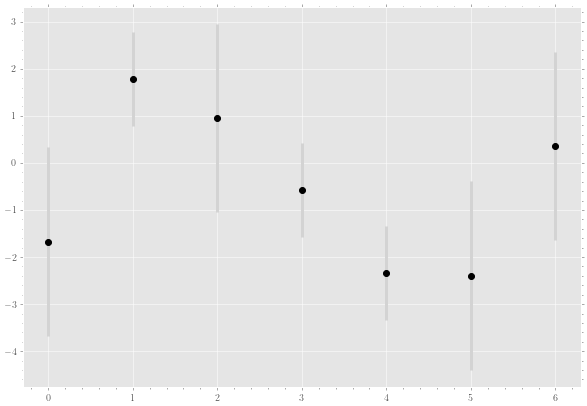

In [73]:
# 观测值的数量
n_observations = 7
x = np.arange(n_observations)

# 虚拟测量值
y = np.sin(x) + np.random.randn(n_observations)

# 测量误差，假设误差服从均匀分布
errors = np.random.randint(1, 3, n_observations)

# 调用ax.errorbar接口，提供3个数组，x, y, yerr
# fmt控制点和线段的样式，跟ax.plot的fmt相同
# color: 控制点的颜色
# ecolor: 代表误差的线段的颜色
# elinewidth: 代表误差的线段的大小
fig, ax = plt.subplots(figsize=(10, 7))
ax.errorbar(x, y, yerr=errors, fmt="o", color="black",
            ecolor="lightgray", elinewidth=3)


In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
estimate = np.random.randn(11)
dup = np.arange(-5, 6)
min95 = estimate - 1.96
max95 = estimate + 1.96

# Create the scatter plot
plt.scatter(dup, estimate, marker='D', color='#FF7A9E')

# Add error bars
plt.errorbar(dup, estimate, yerr=[estimate - min95, max95 - estimate],
             fmt='none', color='#FF7A9E')

# Customize plot appearance
plt.style.use('ggplot')
plt.xlim(-5, 5)
plt.ylim(-4, 4)
plt.xlabel('Weeks before and after the Lockdown')
plt.ylabel('Estimated Coefficient')
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.axvline(-1, color='orange', linewidth=2, linestyle='--')
plt.title('A-3. PM₂̣̣̣̣̣̣̣̣̣̣̣̣̣̣̣̣̣̣̣, log')
plt.text(0.05, -0.8, 'Lockdown', ha='left', va='center', color='black', size=3.5)

# Set custom x-axis labels
x_labels = ['<=-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '>=4']
x_ticks = np.arange(-5, 6)
plt.xticks(x_ticks, x_labels)

# Hide the legend
plt.legend().remove()

# Display the plot
plt.show()

ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of ticklabels (10).

RuntimeError: latex was not able to process the following string:
b'A-3. PM\\u2082\\u0323\\u0323\\u0323\\u0323\\u0323\\u0323\\u0323\\u0323\\u0323\\u0323\\u0323\\u0323\\u0323\\u0323\\u0323\\u0323\\u0323\\u0323\\u0323, log'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../34253fd8df137b437207896082917e1b.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-03-06>
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2020/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2020/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/local/texlive/2020/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/local/texlive/2020/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/local/texlive/2020/texmf-dist/tex/latex/amsfonts/amssymb.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/amsfonts/amsfonts.sty))
(/usr/local/texlive/2020/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 34253fd8df137b437207896082917e1b.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! Package inputenc Error: Unicode character ₂ (U+2082)
(inputenc)                not set up for use with LaTeX.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.18 {\rmfamily A-3. PM₂
                          ̣̣̣̣̣̣̣̣̣̣̣̣̣̣̣̣̣̣̣, log}
No pages of output.
Transcript written on 34253fd8df137b437207896082917e1b.log.




<Figure size 252x189 with 1 Axes>

Summary Statistics

In [258]:
new_df.columns

Index(['name', 'Date', 'text', 'sum', 'Close', 'Return', 'Two_Day_Return',
       'Three_Day_Return', 'Four_Day_Return', 'Five_Day_Return',
       'Six_Day_Return', 'Seven_Day_Return', 'Gain', 'Loss', 'Three_Day_Gain',
       'Three_Day_Loss', 'Three_Day_Volatility', 'Four_Day_Volatility',
       'Five_Day_Volatility', 'Six_Day_Volatility', 'Seven_Day_Volatility',
       'sentiment', 'frequency', 'frequency_log', 'Weekday', 'Month'],
      dtype='object')

In [259]:
# Calculate summary statistics using pandas describe() function
summary_stats = new_df[['Return', 'Two_Day_Return',
       'Three_Day_Return', 'Four_Day_Return', 'Five_Day_Return',
       'Six_Day_Return', 'Seven_Day_Return', 'Gain', 'Loss', 'Three_Day_Gain',
       'Three_Day_Loss', 'Three_Day_Volatility', 'Four_Day_Volatility',
       'Five_Day_Volatility', 'Six_Day_Volatility', 'Seven_Day_Volatility', 'frequency', 'frequency_log','sentiment']].describe()

# Add a column for the number of observations
summary_stats.loc['Observations'] = new_df[['Return', 'Two_Day_Return',
       'Three_Day_Return', 'Four_Day_Return', 'Five_Day_Return',
       'Six_Day_Return', 'Seven_Day_Return', 'Gain', 'Loss', 'Three_Day_Gain',
       'Three_Day_Loss', 'Three_Day_Volatility', 'Four_Day_Volatility',
       'Five_Day_Volatility', 'Six_Day_Volatility', 'Seven_Day_Volatility', 'frequency', 'frequency_log','sentiment']].shape[0]

# Rename the index for the summary statistics table
summary_stats.index.name = 'Statistic'

# Transpose the summary statistics table
summary_stats = summary_stats.transpose()

# Set the desired column order
column_order = ['Observations', 'mean', 'std', 'min', 'max']

# Reorder the columns
summary_stats = summary_stats[column_order]

# Rename the columns
summary_stats.columns = ['Observations', 'Mean', 'SD', 'Min', 'Max']
summary_stats = summary_stats.round(3)

# Export the summary statistics table as LaTeX
latex_table = summary_stats.to_latex(index=True)

# # Print the LaTeX table
print(latex_table)

\begin{tabular}{lrrrrr}
\toprule
{} &  Observations &    Mean &      SD &    Min &      Max \\
\midrule
Return               &        1400.0 &   0.001 &   0.044 & -0.423 &    0.383 \\
Two\_Day\_Return       &        1400.0 &   0.001 &   0.059 & -0.529 &    0.459 \\
Three\_Day\_Return     &        1400.0 &   0.001 &   0.068 & -0.573 &    0.482 \\
Four\_Day\_Return      &        1400.0 &   0.001 &   0.078 & -0.621 &    0.497 \\
Five\_Day\_Return      &        1400.0 &   0.001 &   0.088 & -0.587 &    0.487 \\
Six\_Day\_Return       &        1400.0 &   0.002 &   0.097 & -0.556 &    0.693 \\
Seven\_Day\_Return     &        1400.0 &   0.002 &   0.105 & -0.605 &    0.852 \\
Gain                 &        1400.0 &   0.026 &   0.158 &  0.000 &    1.000 \\
Loss                 &        1400.0 &   0.020 &   0.140 &  0.000 &    1.000 \\
Three\_Day\_Gain       &        1400.0 &   0.074 &   0.262 &  0.000 &    1.000 \\
Three\_Day\_Loss       &        1400.0 &   0.048 &   0.213 &  0.000 &    1.000 \\


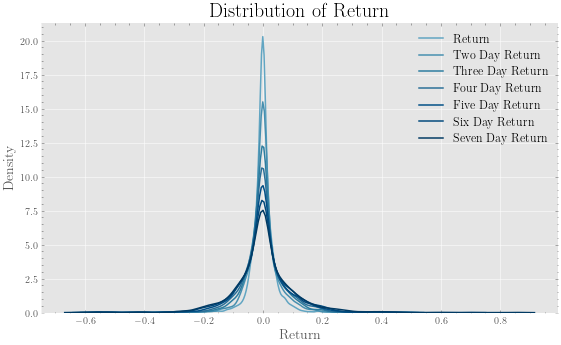

In [351]:
# import seaborn as sns

# colors = ['#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b']
# colors = ["#e6b8a2","#deab90","#d69f7e","#cd9777","#c38e70","#b07d62","#9d6b53"]
colors =["#013a63","#01497c","#014f86","#2a6f97","#2c7da0","#468faf","#61a5c2"][::-1]

with plt.style.context(['science']):
    fig, axs = plt.subplots(1, 1, figsize=(8, 5))
    
    axs.set_title('Distribution of Return', fontsize=20, fontweight='bold')
    sns.kdeplot(new_df.Return, bw_method=0.2, label='Return', color=colors[0], linewidth=1.5,clip=(-1, 1))
    sns.kdeplot(new_df.Two_Day_Return, bw_method=0.2, label='Two Day Return', color=colors[1], linewidth=1.5,clip=(-1, 1))
    sns.kdeplot(new_df.Three_Day_Return, bw_method=0.2, label='Three Day Return', color=colors[2], linewidth=1.5,clip=(-1, 1))
    sns.kdeplot(new_df.Four_Day_Return, bw_method=0.2, label='Four Day Return',color=colors[3],linewidth=1.5,clip=(-1, 1))
    sns.kdeplot(new_df.Five_Day_Return, bw_method=0.2, label='Five Day Return', color=colors[4], linewidth=1.5,clip=(-1, 1))
    sns.kdeplot(new_df.Six_Day_Return, bw_method=0.2, label='Six Day Return',color=colors[5], linewidth=1.5,clip=(-1, 1))
    sns.kdeplot(new_df.Seven_Day_Return, bw_method=0.2, label='Seven Day Return', color=colors[6], linewidth=1.5,clip=(-1, 1))
    
    axs.set_xlabel('Return', fontsize=14)
    axs.set_ylabel('Density', fontsize=14)
    axs.legend(fontsize=12)
    
    sns.despine()
    plt.tight_layout()
    plt.show()
    fig.savefig('graph/Distribution of Return.png', dpi=300)

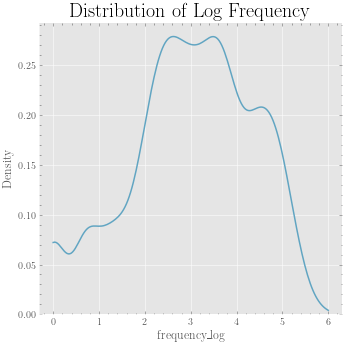

In [354]:
colors =["#013a63","#01497c","#014f86","#2a6f97","#2c7da0","#468faf","#61a5c2"][::-1]

with plt.style.context(['science']):
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    
#     axs.set_title('Distribution of Frequency', fontsize=20, fontweight='bold')
#     sns.kdeplot(new_df.frequency, bw_method=0.2, label='Frequency', color=colors[0], linewidth=1.5,clip=(0, 313))
    axs.set_title('Distribution of Log Frequency', fontsize=20, fontweight='bold')
    sns.kdeplot(new_df.frequency_log, bw_method=0.2, label='Log Frequency', color=colors[0], linewidth=1.5,clip=(0, 6))
#     sns.kdeplot(new_df.frequency_log, bw_method=0.2, label='Two Day Return', color=colors[6], linewidth=1.5)
#     sns.kdeplot(new_df.Three_Day_Return, bw_method=0.2, label='Three Day Return', color=colors[2], linewidth=1.5)
#     sns.kdeplot(new_df.Four_Day_Return, bw_method=0.2, label='Four Day Return',color=colors[3],linewidth=1.5)
#     sns.kdeplot(new_df.Five_Day_Return, bw_method=0.2, label='Five Day Return', color=colors[4], linewidth=1.5)
#     sns.kdeplot(new_df.Six_Day_Return, bw_method=0.2, label='Six Day Return',color=colors[5], linewidth=1.5)
#     sns.kdeplot(new_df.Seven_Day_Return, bw_method=0.2, label='Seven Day Return', color=colors[6], linewidth=1.5)
    
#     axs.set_xlabel('Frequency', fontsize=14)
#     axs.set_ylabel('Density', fontsize=14)
#     axs.legend(fontsize=12)
    
    sns.despine()
    plt.tight_layout()
    plt.show()
    fig.savefig('graph/Distribution of Log Frequency.png', dpi=300)

In [344]:
new_df.sentiment.value_counts()

 0.9999    129
 0.9998     94
 0.0000     88
 0.9997     53
 1.0000     50
          ... 
 0.7667      1
 0.9323      1
 0.8655      1
-0.7506      1
 0.9622      1
Name: sentiment, Length: 460, dtype: int64

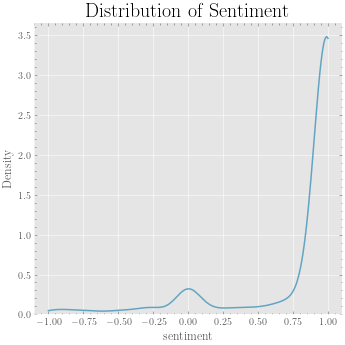

In [361]:
colors =["#013a63","#01497c","#014f86","#2a6f97","#2c7da0","#468faf","#61a5c2"][::-1]

with plt.style.context(['science']):
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    
    axs.set_title('Distribution of Sentiment', fontsize=20, fontweight='bold')
    sns.kdeplot(new_df.sentiment, bw_method=0.2,label='sentiment', color=colors[0], linewidth=1.5,clip=(-1, 1))
    
#     axs.set_title('Cumulative Distribution Function of Sentiment', fontsize=20, fontweight='bold')
#     sns.kdeplot(new_df.sentiment, bw_method=0.2, cumulative=True,label='sentiment', color=colors[0], linewidth=1.5,clip=(-1, 1))
    
#     axs.set_xlim(-1, 1)
    
    sns.despine()
    plt.tight_layout()
    plt.show()
    fig.savefig('graph/Distribution of Sentiment.png', dpi=300)